In [175]:
# import niezbędnych bibliotek
import numpy as np # algebra liniowa
import pandas as pd # manipulowanie danymi
import matplotlib.pyplot as plt # wizualizacja
from matplotlib.colors import ListedColormap
import seaborn as sns
import re # wyrażenia regularne
from sklearn.neighbors import KNeighborsClassifier # model k najbliższych sąsiadów
from sklearn import model_selection # podział danych
from sklearn import metrics # metryki sukcesu

In [12]:
# ładowanie i zrozumienie danych
df = pd.read_csv('data/irises.csv', sep='|')

In [14]:
# wyświetlam 5 pierwszych wierszy danych
df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


In [15]:
# wyświetlam 5 losowych wierszy ze zbioru danych
df.sample(5)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
13,4.8,3.0,1.4,0.1,setosa
128,6.1,3.0,4.9,1.8,virginica
119,7.7,2.6,6.9,2.3,virginica
58,4.9,2.4,3.3,1,versicolor
136,7.7,3.0,6.1,2.3,virginica


Wiem, że mamy 4 atrybuty numeryczne prezentujące szerokość oraz wysokość płatków oraz kielicha.
W zbiorze danych występuje także kolumna z nazwą gatunku Irysa.

In [16]:
# wyświetlam podstawowe informacje na temat zbioru danych
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 150
Data columns (total 5 columns):
Sepal.Length    150 non-null float64
Sepal.Width     149 non-null float64
Petal.Length    150 non-null float64
Petal.Width     150 non-null object
Species         150 non-null object
dtypes: float64(3), object(2)
memory usage: 7.0+ KB


Zbiór ma 4 atrybuty numeryczne typu float64 oraz 1 z nazwami odmian typu object i 150 wierszy. Jest mały, więc łatwo mieści się w pamięci (zajmuje ponad 7.0 KB).
Zauważyłam, że Petal.Width ma typ object, a jest to tym numeryczny (zawiera szerokość płatka), dlatego zmienię tym tego atrybutu na float64. Oprócz tego w jednym z atrybutów występuje pusta wartość (jest 149, a nie 150 wierszy).

Niestety po wykonaniu rzutowania za pomocą .astype() otrzymałam błąd dotyczący braku możliwości zrzutowania ciągu znaków na liczby zmiennoprzecinkowe. W celu rozwiązania problemu wyszukałam element wraz z jego indeksem, który powodował błąd i zmieniłam jego wartość.

In [87]:
# szukam pustych wartości w dataframe
def missing_values(df):
    for column in df.columns:
        null_rows = df[column].isnull()
        if null_rows.any() == True:
            print('%s: %d nulls' % (column, null_rows.sum()))
            
missing_values(df)

Sepal.Width: 1 nulls


W tym wypadku jest to jedna pusta wartość. Postanowiłam wypełnić ją.

In [89]:
df['Sepal.Width'] = df['Sepal.Width'].interpolate(method='linear')
missing_values(df)

In [72]:
regex = re.compile('^[0-9]+\.[0-9]+$')

for index, element in enumerate(df['Petal.Width']):
    if not regex.match(element):
        print(index, element)

57 1
60 1
62 1
67 1
79 1
81 1
93 1
110 2
113 2
121 2
122 2
131 2
132 2,2
147 2


In [78]:
df['Petal.Width'].iat[132] = 2.2

In [79]:
df['Petal.Width'] = df['Petal.Width'].astype('float64')

In [21]:
df.columns

Index(['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width',
       'Species'],
      dtype='object')

Powyżej wyświetliłam nazwy kolumn występujących w zbiorze danych.

In [18]:
df.shape

(150, 5)

Kształt zbioru danych potwierdza moje wcześniejsze stwierdzenie.

In [85]:
df.describe()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,150.000000,149.000000,150.000000,150.000000
mean,5.779333,3.061745,3.758000,1.200667
std,1.197721,0.433963,1.765298,0.763821
min,-4.800000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Dzięki tej funkcji widzę podstawowe metryki statystyczne: ilość, średnią, odchylenie standardowe, minimalną i maksymalną wartość oraz kwartyle.

Ciekawym spostrzeżeniem jest ujemna wartość jako minimalna wartość dla Sepal.Length, zliczenie Sepal.Width równe 149.

In [23]:
df.isnull().all()

Sepal.Length    False
Sepal.Width     False
Petal.Length    False
Petal.Width     False
Species         False
dtype: bool

Sprawdziłam, czy w którejś z kolumn występują puste wartości w danej kolumnie, ponieważ zdziwił mnie fakt, że funkcja .describe() zwróciła ilość 149 dla Sepal.Width.
Jednak funkcja .isnull() pokazuje, że nie ma pustych wartości w żadnej z kolumn.

In [24]:
df.nunique()

Sepal.Length    36
Sepal.Width     23
Petal.Length    43
Petal.Width     23
Species          3
dtype: int64

Unikalne wartości w każdej z kolumn.

In [80]:
df.corr()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
Sepal.Length,1.000000,-0.126954,0.659321,0.637817
Sepal.Width,-0.126954,1.000000,-0.432109,-0.367973
Petal.Length,0.659321,-0.432109,1.000000,0.963500
Petal.Width,0.637817,-0.367973,0.963500,1.000000


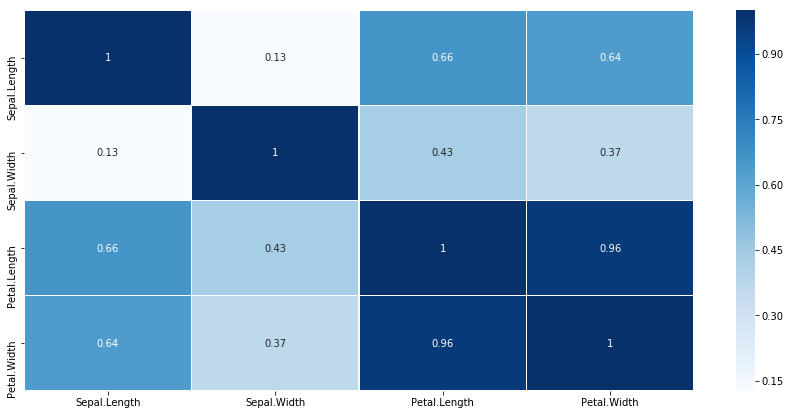

In [81]:
plt.rcParams['figure.figsize']=(15,7)
sns.heatmap(df.corr().abs(), annot=True, linewidths=.5, cmap="Blues");

Korelacja między kolumnami:
    - Sepal.Length i Sepal.Width korelacja ujemna;
    - Sepal.Length i Petal.Length korelacja dodatnia;
    - Sepal.Width i Petal.Length korelacja dodatnia;
    - Sepal.Width i Petal.Width korelacja dodatnia;
    
Silnie skorelowane są Petal.Length oraz Petal.Width.

In [28]:
df.groupby('Species').size()

Species
setosa        50
versicolor    50
virginica     50
dtype: int64

Pogrupowanie gatunków irysów ze względu na ilość wierszy.

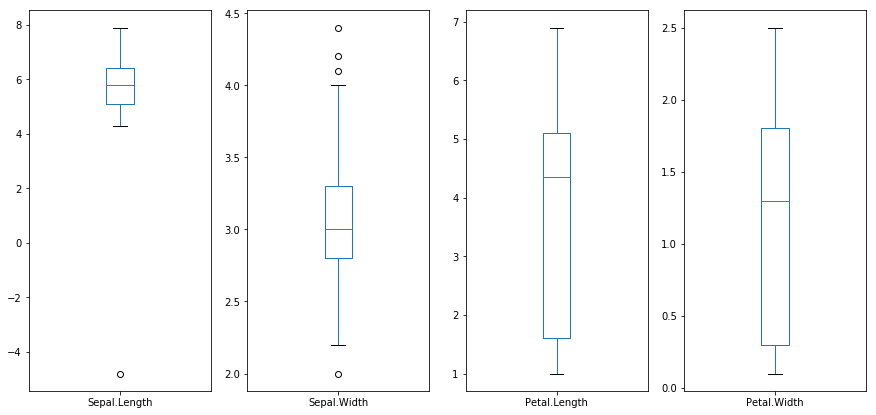

In [82]:
# wizualizacja
df.plot(kind='box', subplots=True);

Na wykresach powyżej widzimy zakresy wartości i odchylenia w danych kolumnach.

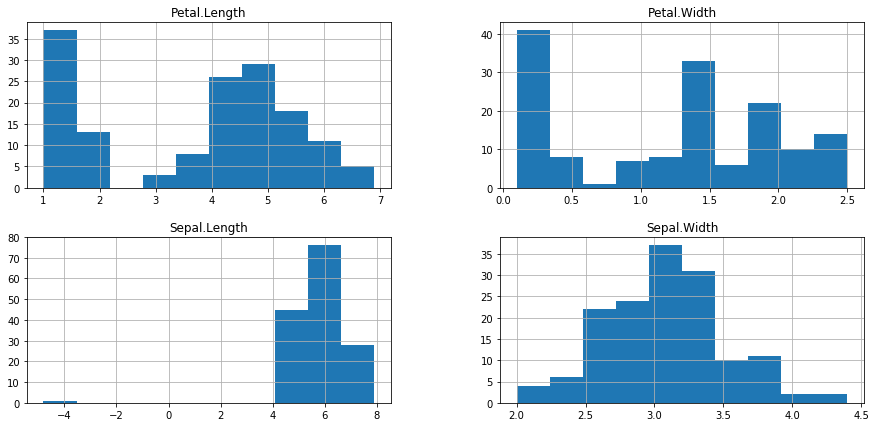

In [83]:
df.hist();

Histogram to wykres dotyczący rozkładu wartości w danym atrybucie.

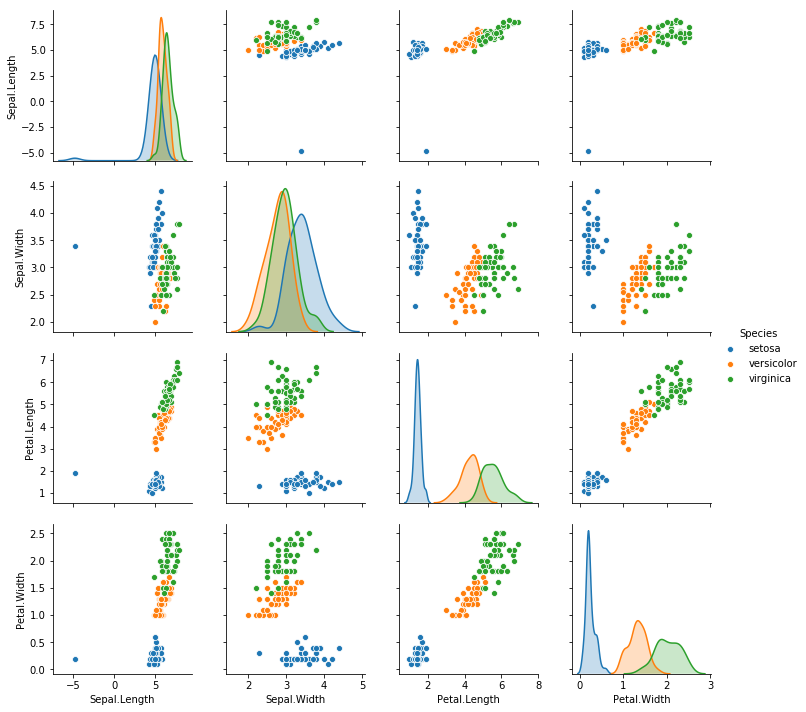

In [91]:
sns.pairplot(df, hue='Species');

Wykres typu scatter obrazuje nam, jak działa jeden atrybut na inny. Na tego typu wykresie wykryjemy relacje między dwoma atrybutami.

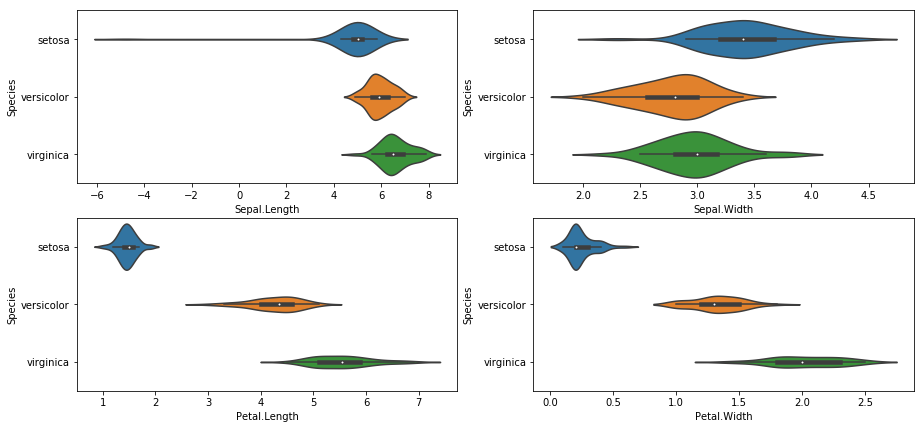

In [103]:
plt.subplot(2,2,1)
sns.violinplot(y='Species', x='Sepal.Length', data=df)
plt.subplot(2,2,2)
sns.violinplot(y='Species', x='Sepal.Width', data=df)
plt.subplot(2,2,3)
sns.violinplot(y='Species', x='Petal.Length', data=df)
plt.subplot(2,2,4)
sns.violinplot(y='Species', x='Petal.Width', data=df);

Wykresy czterech atrybutów względem gatunków.

In [204]:
X = df[['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']]
y = df['Species']

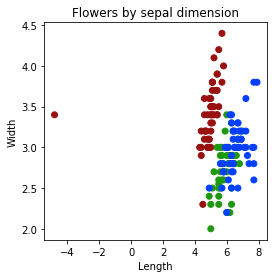

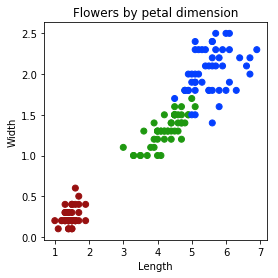

In [224]:
# zwizualizowany rozkład trzech gatunków irysów względem wymiarów płatka i kielicha
cmap_bold  = ListedColormap(['#981010', '#1E9810', '#043FFF'])

fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(np.array(X)[:,0], np.array(X)[:,1], c=pd.factorize(y)[0], cmap=cmap_bold);
ax.set(title='Flowers by sepal dimension', ylabel='Width', xlabel='Length');

fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(np.array(X)[:,2], np.array(X)[:,3], c=pd.factorize(y)[0], cmap=cmap_bold);
ax.set(title='Flowers by petal dimension', ylabel='Width', xlabel='Length');

In [165]:
df_train, df_test = model_selection.train_test_split(df, test_size = 0.2)

In [168]:
clf = neighbors.KNeighborsClassifier(3, weights='distance')
clf.fit(df_train.iloc[:,0:4], df_train.iloc[:,4])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='distance')

In [176]:
y_pred = clf.predict(df_test.iloc[:,0:4])

In [178]:
metrics.accuracy_score(y_pred, df_test.iloc[:,-1])

0.9333333333333333

Mój model ma dokładność na poziomie około 93%.